# Inspect Aquaculture Training Data

Inspect and visualize data loading and pre-processing code.

In [1]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
import time
import concurrent.futures
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import imgaug
from imgaug import augmenters as iaa

# import crop_mask
import aqua_configs
import aqua_dataset
import aqua_preprocess as pp
import aqua_visualize as visualize

# Import Mask RCNN
# sys.path.insert(0,pp.ROOT)
from mrcnn import utils
# from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model as modellib
from mrcnn.model import log

%matplotlib inline 

# Comment out to reload imported modules if they change
%load_ext autoreload
%autoreload 

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

In [36]:
config = aqua_configs.AquaConfig

# Use configuation from crop_mask.py, but override
# image resizing so we see the real sizes here
class NoResizeConfig(aqua_configs.AquaConfig):
    IMAGE_RESIZE_MODE = "none"
    
config = NoResizeConfig(3)

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=25):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Create Dataset

First, let's create new training and testing sets from the directory of gridded Planet images. This directory contains batches of training data, so first we need to specify which batch(es) to use:

In [4]:
data_for_model = os.path.join(pp.PREPPED, 'china_20180918')

In [5]:
# Create fresh Train/Test split batch after clearing previously processed images and replacing
pp.train_test_split(data_for_model, pp.TRAIN, pp.TEST, kprop=0.1)

Next we create the aquaculture dataset

In [6]:
# Create training dataset
dataset = aqua_dataset.AquaDataset()
dataset.load_aqua(pp.DATASET, "train")
dataset.prepare()

Now let's visualize some random image samples

<Figure size 1008x504 with 0 Axes>

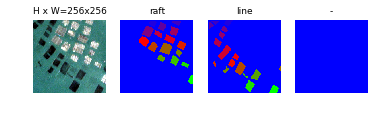

<Figure size 1008x504 with 0 Axes>

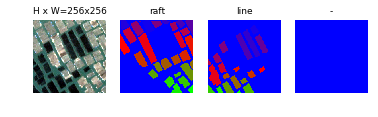

<Figure size 1008x504 with 0 Axes>

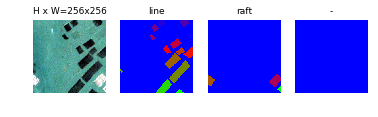

<Figure size 1008x504 with 0 Axes>

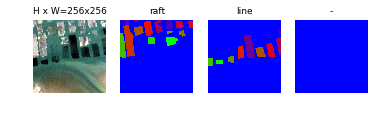

In [7]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    image = visualize.reorder_to_rgb(image)
#     print(image.shape)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit = 3)

## Display Samples 


/home/tclavelle/tana-crunch/CropMask_RCNN/data/aqua/train/20180410_020421_0f31_11_25/image/20180410_020421_0f31_11_25.tif
(256, 256, 35)


<Figure size 1008x1008 with 0 Axes>

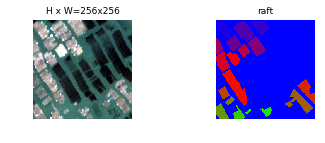

/home/tclavelle/tana-crunch/CropMask_RCNN/data/aqua/train/20180410_020421_0f31_6_1/image/20180410_020421_0f31_6_1.tif
(256, 256, 18)


<Figure size 1008x1008 with 0 Axes>

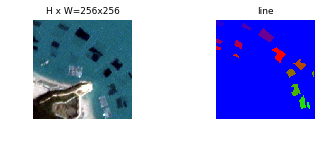

/home/tclavelle/tana-crunch/CropMask_RCNN/data/aqua/train/20180410_020421_0f31_1_5/image/20180410_020421_0f31_1_5.tif
(256, 256, 17)


<Figure size 1008x1008 with 0 Axes>

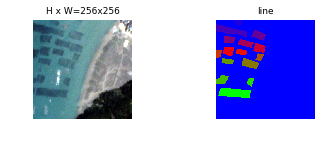

/home/tclavelle/tana-crunch/CropMask_RCNN/data/aqua/train/20180410_020421_0f31_11_17/image/20180410_020421_0f31_11_17.tif
(256, 256, 43)


<Figure size 1008x1008 with 0 Axes>

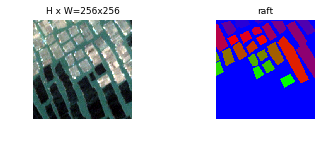

/home/tclavelle/tana-crunch/CropMask_RCNN/data/aqua/train/20180410_020421_0f31_7_21/image/20180410_020421_0f31_7_21.tif
(256, 256, 42)


<Figure size 1008x1008 with 0 Axes>

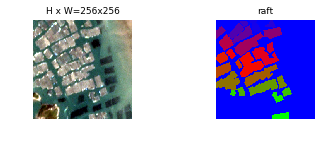

/home/tclavelle/tana-crunch/CropMask_RCNN/data/aqua/train/20180410_020421_0f31_8_3/image/20180410_020421_0f31_8_3.tif
(256, 256, 28)


<Figure size 1008x1008 with 0 Axes>

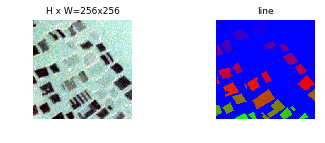

In [8]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 6)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    image = visualize.reorder_to_rgb(image)
    mask, class_ids = dataset.load_mask(image_id)
    #need to reorder and show RGB from 8 channel WV2. 
    print(dataset.source_image_link(image_id))
    print(mask.shape)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=1)

Works, but still need to find better RGB stretching method. Stretching is applied in mrcnn/visualize.py with skimage.exposure

molded_image             shape: (256, 256, 3)         min:  488.00000  max: 3472.00000  uint16
mask                     shape: (256, 256, 29)        min:    0.00000  max:    1.00000  bool


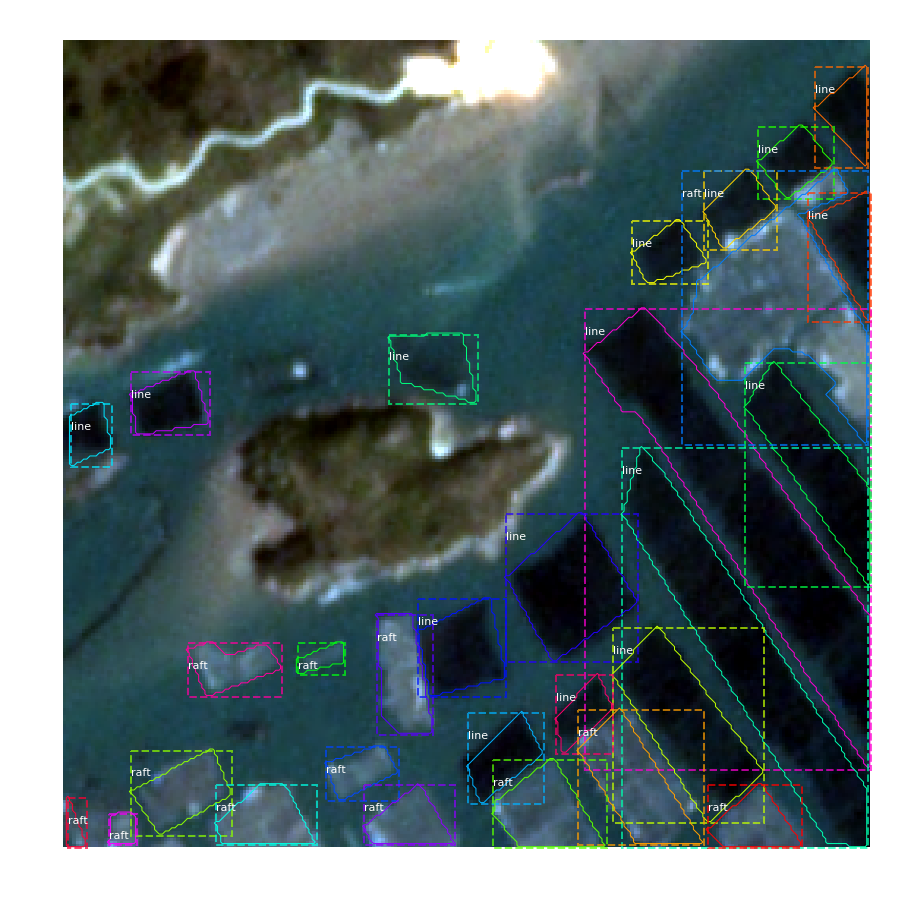

In [9]:
# Example of loading a specific image by its source ID
source_id = "20180410_020421_0f31_10_17"

# Map source ID to Dataset image_id
# Notice the aqua prefix: it's the name given to the dataset in AquaDataset
image_id = dataset.image_from_source_map["aqua.{}".format(source_id)]

# Load and display
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, config, image_id, use_mini_mask=False)
log("molded_image", image)
log("mask", mask)
image = visualize.reorder_to_rgb(image)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names,
                            show_bbox=True)

## Dataset Stats

Loop through all images in the dataset and collect aggregate stats.

In [10]:
print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 183
Class Count: 5
  0. BG                                                
  1. line                                              
  2. raft                                              
  3. pond                                              
  4. cage                                              


In [11]:
def image_stats(image_id):
    """Returns a dict of stats for one image."""
    image = dataset.load_image(image_id)
    mask, _ = dataset.load_mask(image_id)
    bbox = utils.extract_bboxes(mask)
    # Sanity check
    assert mask.shape[:2] == image.shape[:2]
    # Return stats dict
    return {
        "id": image_id,
        "shape": list(image.shape),
        "bbox": [[b[2] - b[0], b[3] - b[1]]
                 for b in bbox
                 # Uncomment to exclude fields with 1 pixel width
                 # or height (often on edges)
                 if b[2] - b[0] > 1 and b[3] - b[1] > 1
                ],
        "color": np.mean(image, axis=(0, 1)),
    }

# Loop through the dataset and compute stats over multiple threads
# This might take a few minutes
t_start = time.time()
with concurrent.futures.ThreadPoolExecutor() as e:
    stats = list(e.map(image_stats, dataset.image_ids))
t_total = time.time() - t_start
print("Total time: {:.1f} seconds".format(t_total))

Total time: 2.5 seconds


In [12]:
means = [image['color'] for image in stats]
means = np.array(means)
means.mean(axis = 0)

array([756.72233265, 850.44464278, 740.32534265])

### Image Size Stats

Summarize the sizes of images in the dataset. At the moment, all images are 256x256. Should add larger image chips after developing a better gridding method

Image Count:  183
Height  mean: 256.00  median: 256.00  min: 256.00  max: 256.00
Width   mean: 256.00  median: 256.00  min: 256.00  max: 256.00
Color   mean (RGB): 756.72 850.44 740.33


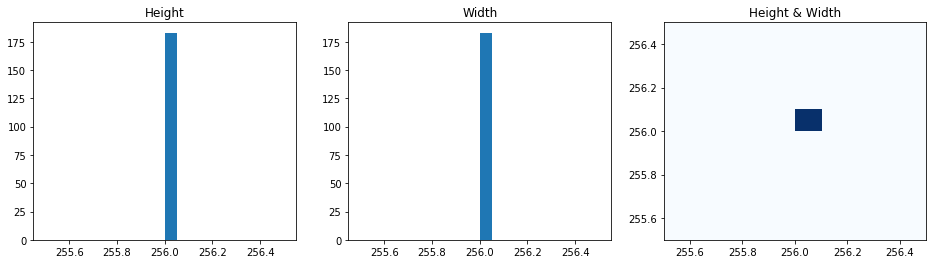

In [13]:
# Image stats
image_shape = np.array([s['shape'] for s in stats])
image_color = np.array([s['color'] for s in stats])
print("Image Count: ", image_shape.shape[0])
print("Height  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(image_shape[:, 0]), np.median(image_shape[:, 0]),
    np.min(image_shape[:, 0]), np.max(image_shape[:, 0])))
print("Width   mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(image_shape[:, 1]), np.median(image_shape[:, 1]),
    np.min(image_shape[:, 1]), np.max(image_shape[:, 1])))
print("Color   mean (RGB): {:.2f} {:.2f} {:.2f}".format(*np.mean(image_color, axis=0)))

# Histograms
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].set_title("Height")
_ = ax[0].hist(image_shape[:, 0], bins=20)
ax[1].set_title("Width")
_ = ax[1].hist(image_shape[:, 1], bins=20)
ax[2].set_title("Height & Width")
_ = ax[2].hist2d(image_shape[:, 1], image_shape[:, 0], bins=10, cmap="Blues")

### Aquaculture Objects per Image Stats

Calculate how many aquaculture objects from various classes are in each image.

Aquaculture/Image
Image area <=  600**2:  mean: 25.1  median: 26.0  min: 1.0  max: 75.0


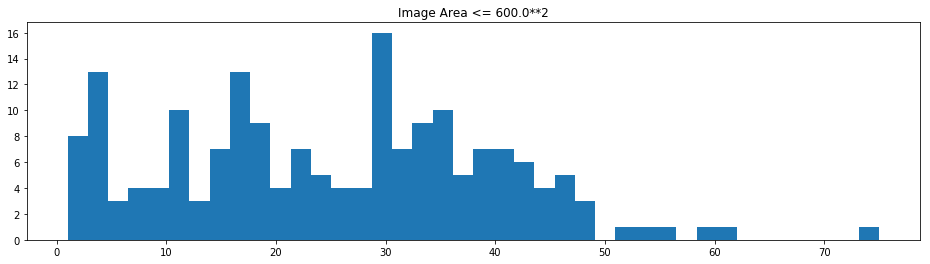

In [14]:
# Segment by image area, edited to only work with one area threshold, for loop not needed but doesn't hurt
image_area_bins = [600**2]

print("Aquaculture/Image")
fig, ax = plt.subplots(1, len(image_area_bins), figsize=(16, 4))
area_threshold = 0
for i, image_area in enumerate(image_area_bins):
    fields_per_image = np.array([len(s['bbox']) 
                                 for s in stats 
                                 if area_threshold < (s['shape'][0] * s['shape'][1]) <= image_area])
    area_threshold = image_area
    if len(fields_per_image) == 0:
        print("Image area <= {:4}**2: None".format(np.sqrt(image_area)))
        continue
    print("Image area <= {:4.0f}**2:  mean: {:.1f}  median: {:.1f}  min: {:.1f}  max: {:.1f}".format(
        np.sqrt(image_area), fields_per_image.mean(), np.median(fields_per_image), 
        fields_per_image.min(), fields_per_image.max()))
    ax.set_title("Image Area <= {:4}**2".format(np.sqrt(image_area)))
    _ = ax.hist(fields_per_image, bins=40)

### Object Size Stats

{'id': 0, 'shape': [256, 256, 3], 'bbox': [[40, 36], [88, 61], [26, 26], [7, 23], [83, 54], [84, 51], [56, 50], [28, 12], [41, 31], [26, 16], [115, 36], [81, 48], [33, 29], [60, 39], [75, 42], [65, 47], [35, 28], [40, 36], [32, 27], [43, 38], [35, 28], [52, 36], [32, 36], [39, 34], [49, 21], [37, 34], [61, 51], [64, 51], [34, 31], [38, 34], [24, 13], [50, 48], [26, 27], [55, 51], [52, 53], [39, 34], [32, 34], [37, 43], [28, 29], [25, 30], [22, 19], [12, 18], [8, 12]], 'color': array([668.96124268, 718.10087585, 581.03208923])}

Image Area <= 600**2 units are in pixels
  Total aquaculture objects:  4594
  object Height. mean: 35.32  median: 30.00  min: 2.00  max: 233.00
  object Width.  mean: 36.85  median: 31.00  min: 3.00  max: 256.00
  object Area.   mean: 1575.11  median: 945.00  min: 12.00  max: 43005.00


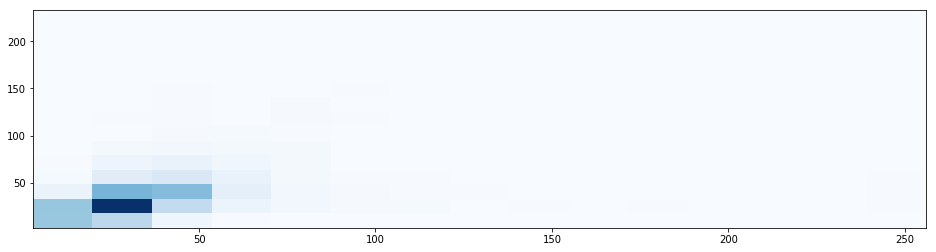

In [15]:
# Farm size stats
fig, ax = plt.subplots(1, len(image_area_bins), figsize=(16, 4))
area_threshold = 0
for i, image_area in enumerate(image_area_bins):
    field_shape = np.array([
        b
        for s in stats if area_threshold < (s['shape'][0] * s['shape'][1]) <= image_area
        for b in s['bbox']])
    print(stats[0])
    field_area = field_shape[:, 0] * field_shape[:, 1]
    area_threshold = image_area

    print("\nImage Area <= {:.0f}**2 units are in pixels".format(np.sqrt(image_area)))
    print("  Total aquaculture objects: ", field_shape.shape[0])
    print("  object Height. mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(field_shape[:, 0]), np.median(field_shape[:, 0]),
        np.min(field_shape[:, 0]), np.max(field_shape[:, 0])))
    print("  object Width.  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(field_shape[:, 1]), np.median(field_shape[:, 1]),
        np.min(field_shape[:, 1]), np.max(field_shape[:, 1])))
    print("  object Area.   mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(field_area), np.median(field_area),
        np.min(field_area), np.max(field_area)))

    # Show 2D histogram
    _ = ax.hist2d(field_shape[:, 1], field_shape[:, 0], bins=15, cmap="Blues")

Object Aspect Ratio.  mean: 1.14  median: 1.00  min: 0.04  max: 10.67


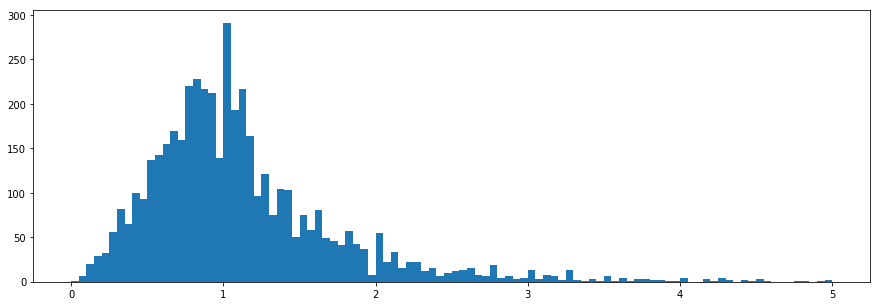

In [16]:
# Object height/width ratio
field_aspect_ratio = field_shape[:, 0] / field_shape[:, 1]
print("Object Aspect Ratio.  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(field_aspect_ratio), np.median(field_aspect_ratio),
    np.min(field_aspect_ratio), np.max(field_aspect_ratio)))
plt.figure(figsize=(15, 5))
_ = plt.hist(field_aspect_ratio, bins=100, range=[0, 5])

## Image Augmentation

Test out different augmentation methods

In [17]:
# List of augmentations
# http://imgaug.readthedocs.io/en/latest/source/augmenters.html
augmentation = iaa.OneOf([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.GaussianBlur(sigma=(0.1, 2.0)),
#     iaa.AdditiveGaussianNoise(scale=0.9)
])

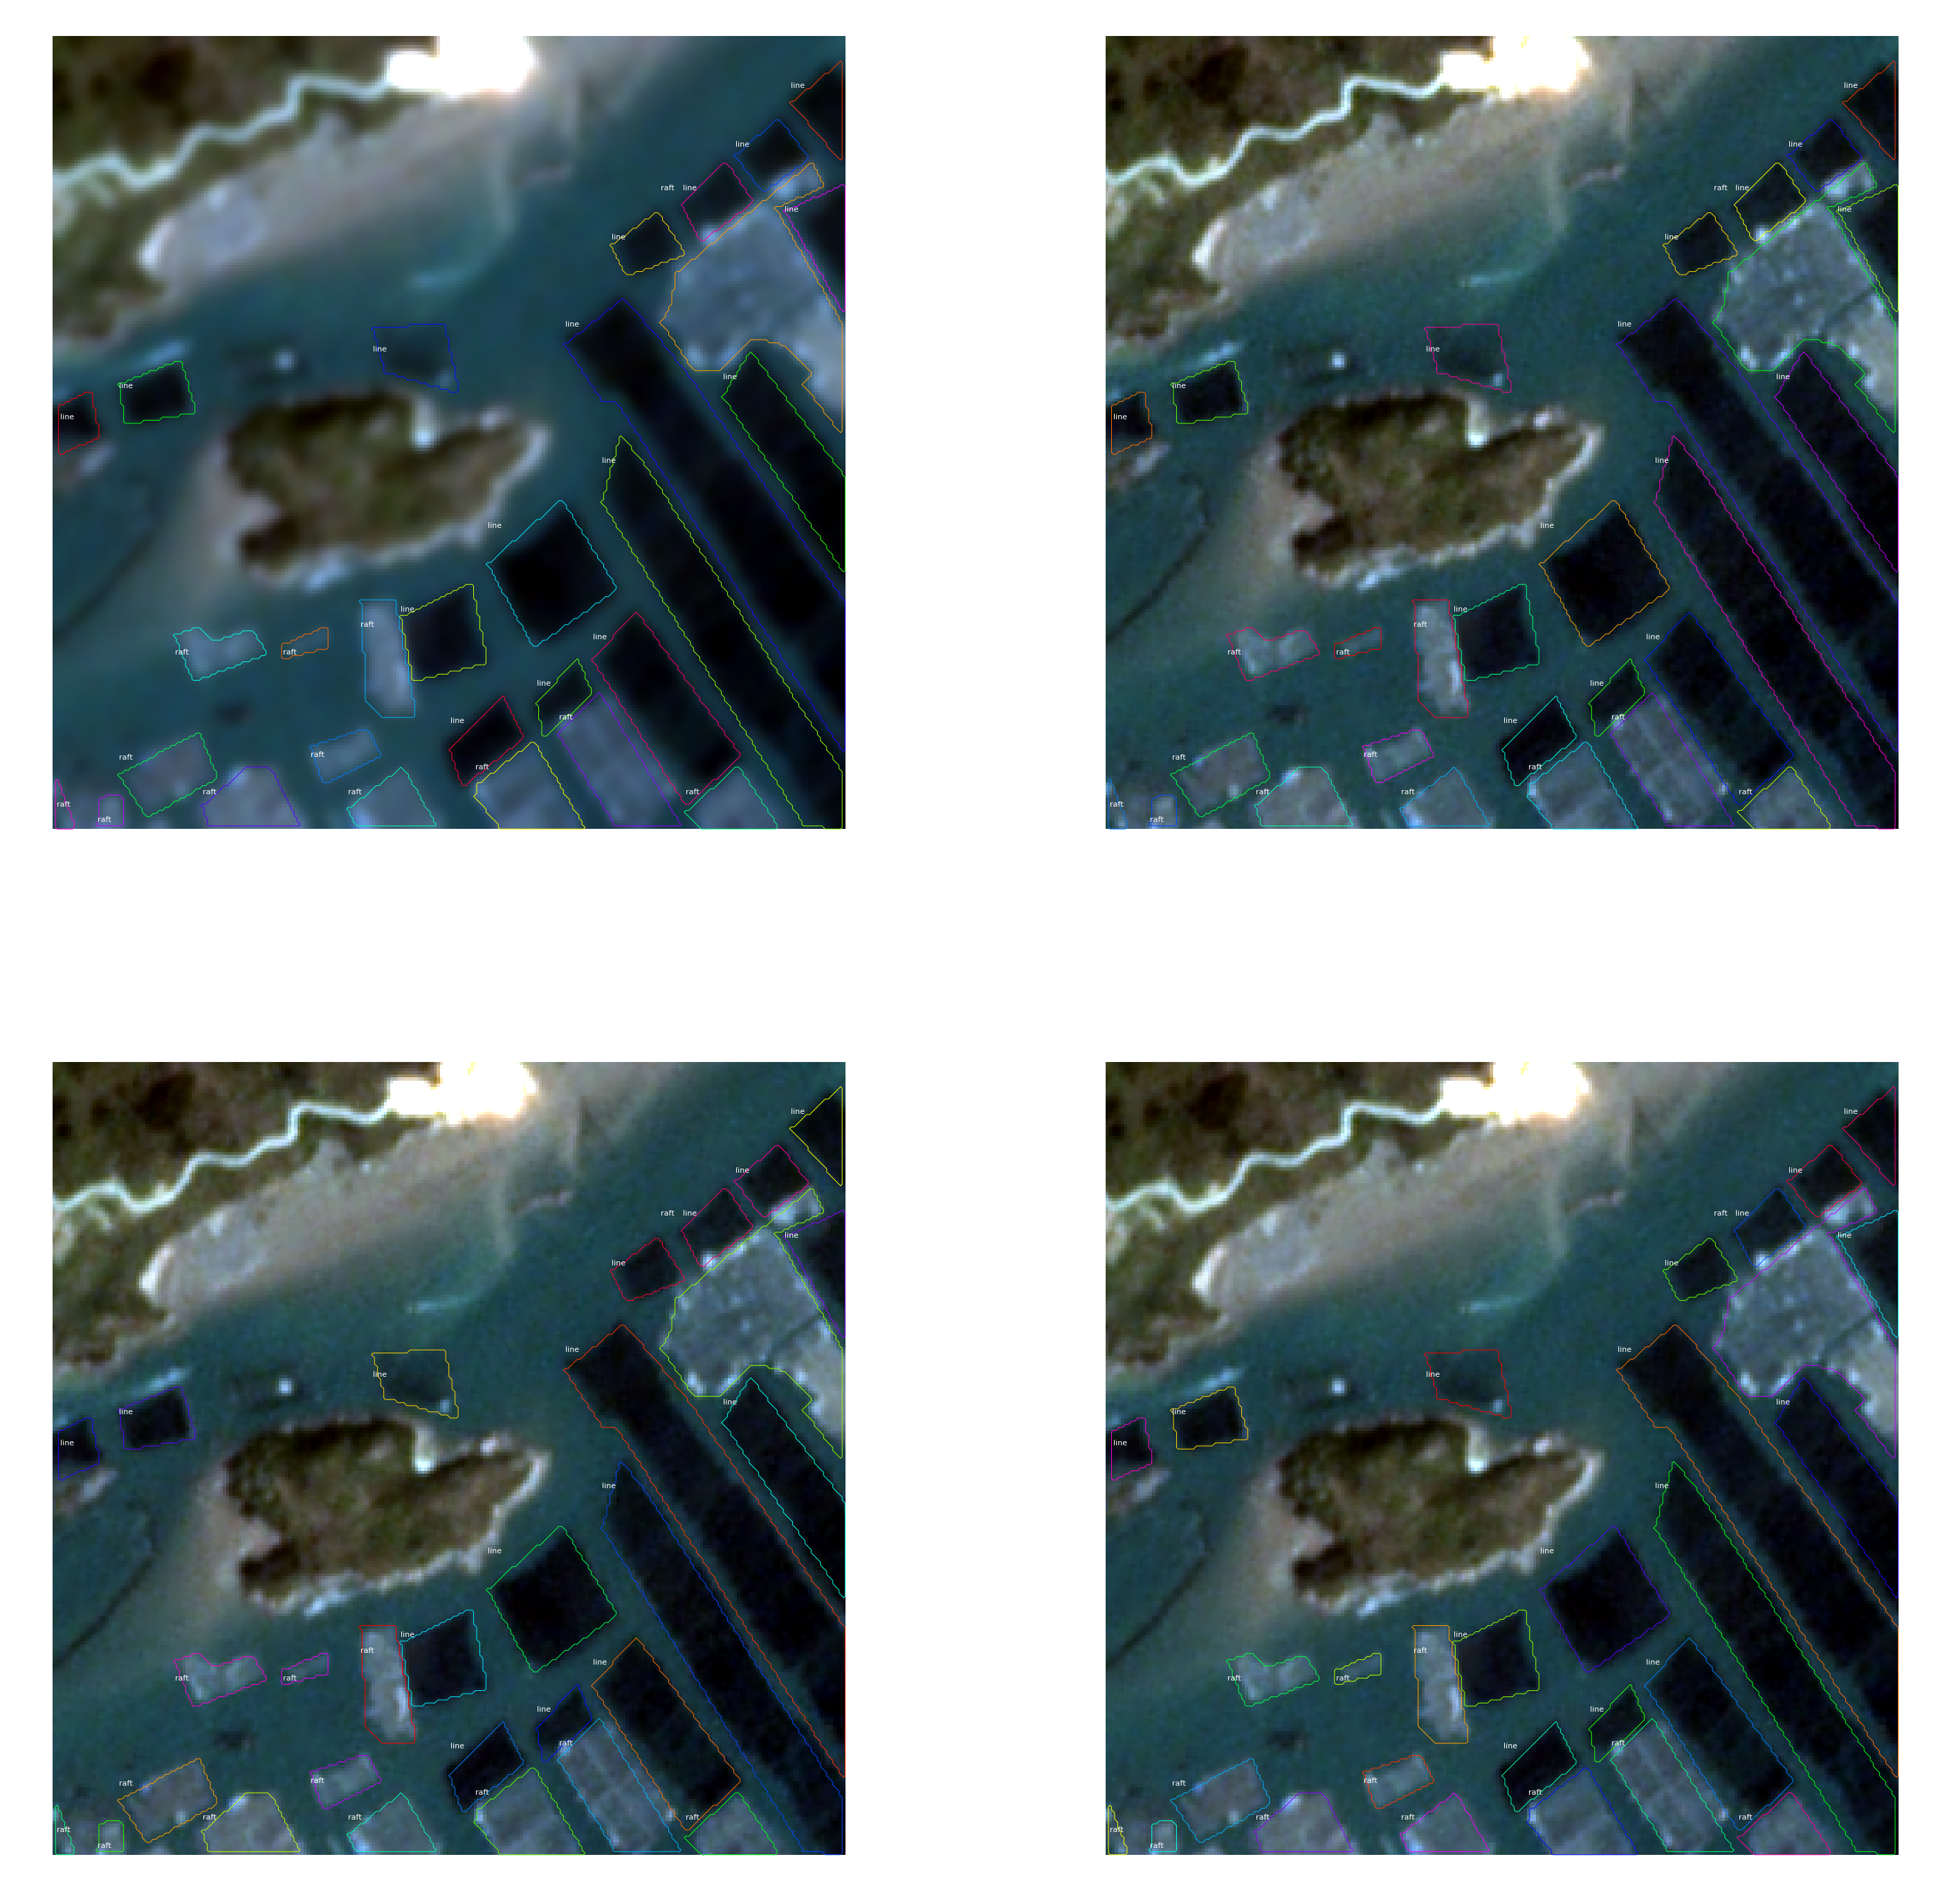

In [18]:
# Load the image multiple times to show augmentations
limit = 4
ax = get_ax(rows=2, cols=limit//2)
for i in range(limit):
    image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, config, image_id, use_mini_mask=False, augment=False, augmentation=augmentation)
    image = visualize.reorder_to_rgb(image)
    visualize.display_instances(image, bbox, mask, class_ids,
                                dataset.class_names, ax=ax[i//2, i % 2],
                                show_mask=False, show_bbox=False)

## Image Crops

Our gridded images are small (about 260x260) so we probably don't need to crop them before hand. 

In [19]:
class RandomCropConfig(aqua_configs.AquaConfig):
    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

crop_config = RandomCropConfig(3)

## Mini Masks
Below is the decription for the nucleus dataset. Since field size on average is about 78x78 and there are still quite a few fields that are larger, it is probably best not to optimize with mini masks, especially since our gridded images are noth that large - 256x256.

Instance binary masks can get large when training with high resolution images. For example, if training with 1024x1024 image then the mask of a single instance requires 1MB of memory (Numpy uses bytes for boolean values). If an image has 100 instances then that's 100MB for the masks alone. 

To improve training speed, we optimize masks:
* We store mask pixels that are inside the object bounding box, rather than a mask of the full image. Most objects are small compared to the image size, so we save space by not storing a lot of zeros around the object.
* We resize the mask to a smaller size (e.g. 56x56). For objects that are larger than the selected size we lose a bit of accuracy. But most object annotations are not very accuracy to begin with, so this loss is negligable for most practical purposes. Thie size of the mini_mask can be set in the config class.

To visualize the effect of mask resizing, and to verify the code correctness, we visualize some examples.

image_id:  100 None
Original shape:  (256, 256, 3)
image                    shape: (256, 256, 3)         min:    0.12396  max:    1.00000  float64
mask                     shape: (256, 256, 5)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (5,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (5, 4)                min:  164.00000  max:  256.00000  int32


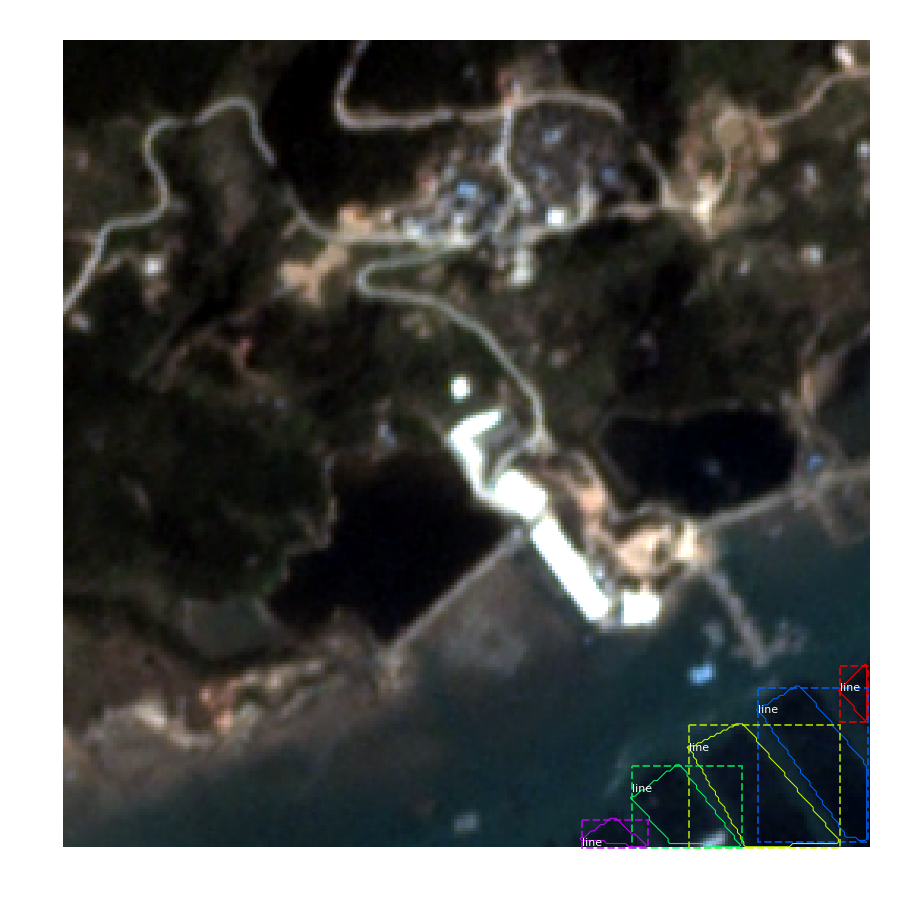

In [20]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
image = visualize.reorder_to_rgb(image)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

*Above code fails for images with no aquaculture objects

image                    shape: (256, 256, 3)         min:  464.00000  max: 2616.00000  uint16
image_meta               shape: (17,)                 min:    0.00000  max:  256.00000  int64
class_ids                shape: (37,)                 min:    1.00000  max:    2.00000  int32
bbox                     shape: (37, 4)               min:    0.00000  max:  256.00000  int32
mask                     shape: (256, 256, 37)        min:    0.00000  max:    1.00000  bool


<Figure size 1008x720 with 0 Axes>

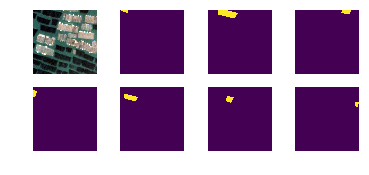

In [21]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

image = visualize.reorder_to_rgb(image)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

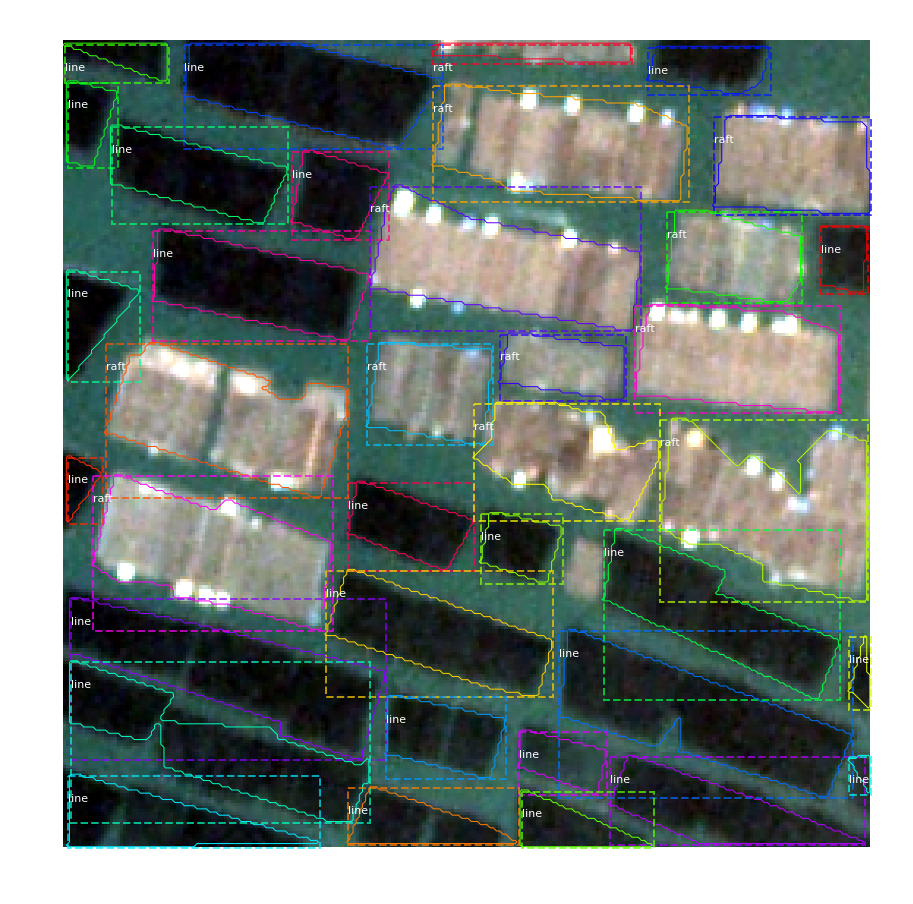

In [22]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

mask                     shape: (56, 56, 37)          min:    0.00000  max:    1.00000  bool


<Figure size 1008x720 with 0 Axes>

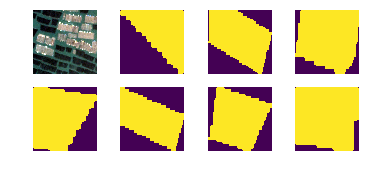

In [23]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
image = visualize.reorder_to_rgb(image)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

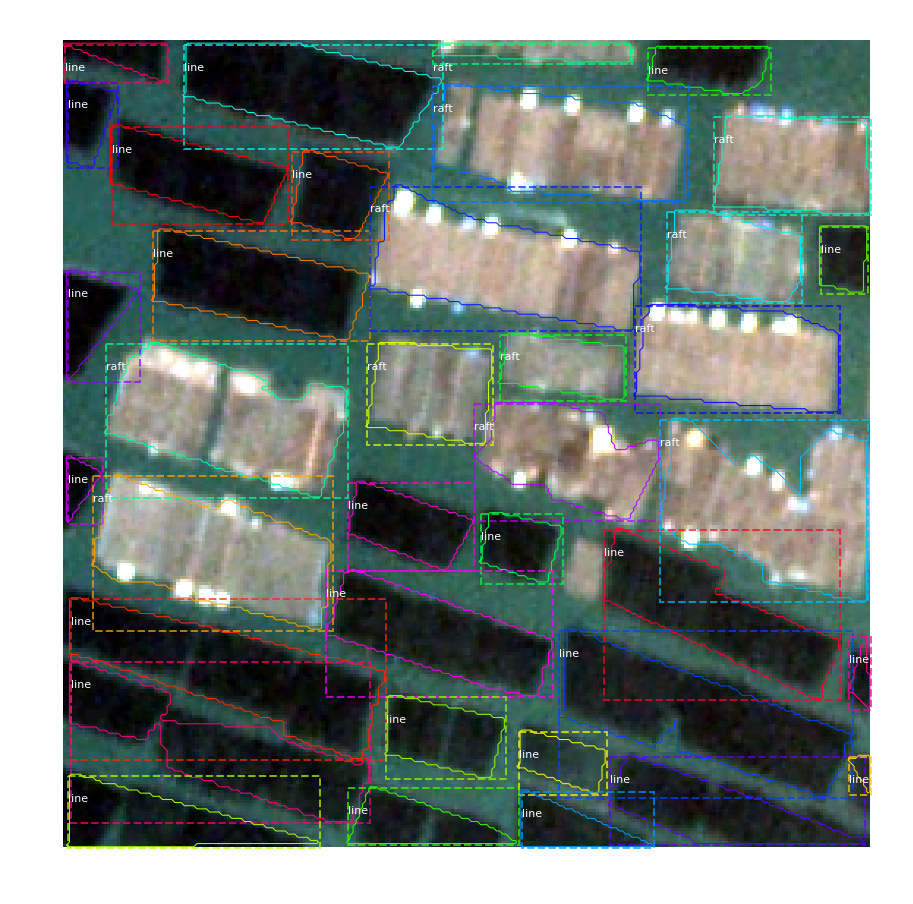

In [24]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Anchors

For an FPN network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts. 
* Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
* Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row. 
* For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.

Count:  16320
Scales:  (20, 60, 100, 140)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 12288
Anchors in Level 1: 3072
Anchors in Level 2: 768
Anchors in Level 3: 192
Anchors in Level 4: 48


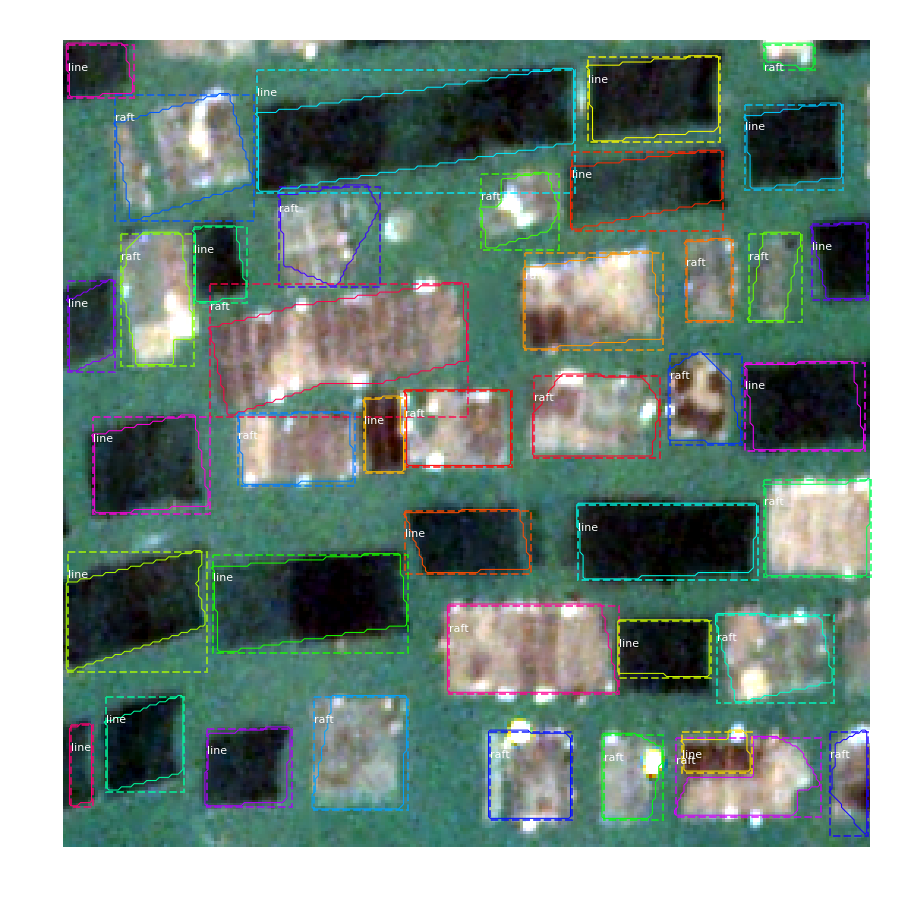

Level 0. Anchors:  12288  Feature map Shape: [64 64]
Level 1. Anchors:   3072  Feature map Shape: [32 32]
Level 2. Anchors:    768  Feature map Shape: [16 16]
Level 3. Anchors:    192  Feature map Shape: [8 8]
Level 4. Anchors:      0  Feature map Shape: [4 4]


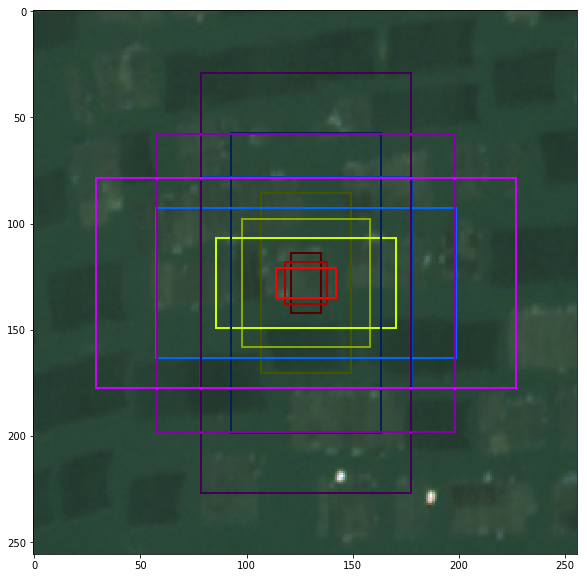

In [25]:
## Visualize anchors of one cell at the center of the feature map

# Load and display random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(dataset, config, image_id)

image = visualize.reorder_to_rgb(image)

# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, image.shape)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

# Display
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)
fig, ax = plt.subplots(1, figsize=(10, 10))
# image = reorder_to_brg(image)
# image = exposure.equalize_adapthist(image, clip_limit=0.0055)
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


## Data Generator

In [40]:
# Create data generator
random_rois = 20
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [ ]:
# Uncomment to run the generator through a lot of images
# to catch rare errors
# for i in range(1000):
#     print(i)
#     _, _ = next(g)

In [41]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (4, 100, 4)           min:    0.00000  max:  255.00000  int32
mrcnn_class_ids          shape: (4, 100, 1)           min:    0.00000  max:    0.00000  int32
mrcnn_bbox               shape: (4, 100, 5, 4)        min:    0.00000  max:    0.00000  float32
mrcnn_mask               shape: (4, 100, 28, 28, 5)   min:    0.00000  max:    0.00000  float32
gt_class_ids             shape: (4, 3)                min:    1.00000  max:    3.00000  int32
gt_boxes                 shape: (4, 3, 4)             min:    1.00000  max:  256.00000  int32
gt_masks                 shape: (4, 256, 256, 3)      min:    0.00000  max:    1.00000  bool
rpn_match                shape: (4, 65280, 1)         min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (4, 256, 4)           min:   -6.01986  max:    4.24264  float64
image_id:  150 None


not showing true color for some reason, due to normalization in cell above?

anchors                  shape: (16320, 4)            min:  -98.99495  max:  322.99495  float64
refined_anchors          shape: (4, 4)                min:    9.00000  max:  138.00000  float32
Positive anchors: 4
Negative anchors: 252
Neutral anchors: 65024
BG                     : 100


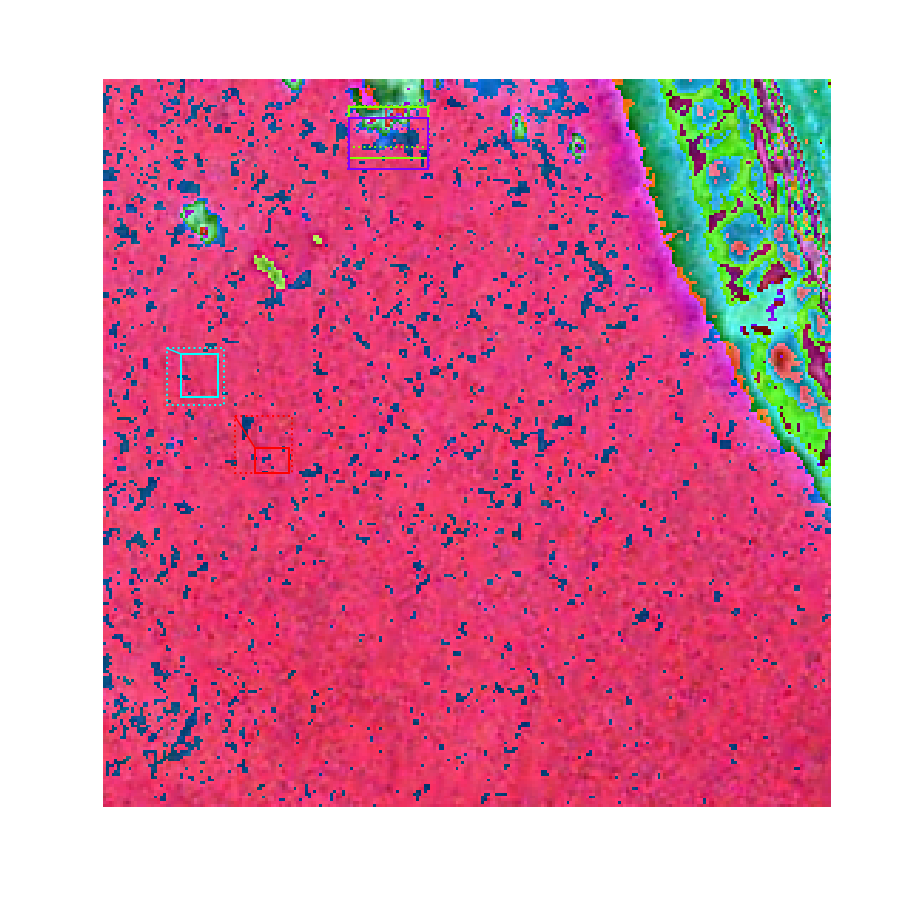

In [45]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))
        
# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors, ax=ax)

Looks like there are a lot of negative anchors that fall within the large positive anchors, why is this? What determines if an anchor is positive or negative?

In [46]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

IndexError: index 16568 is out of bounds for axis 0 with size 16320

In [47]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

IndexError: index 37948 is out of bounds for axis 0 with size 16320

## ROIs

Typically, the RPN network generates region proposals (a.k.a. Regions of Interest, or ROIs). The data generator has the ability to generate proposals as well for illustration and testing purposes. These are controlled by the `random_rois` parameter.

Positive ROIs:  0
Negative ROIs:  100
Positive Ratio: 0.00
Unique ROIs: 20 out of 100


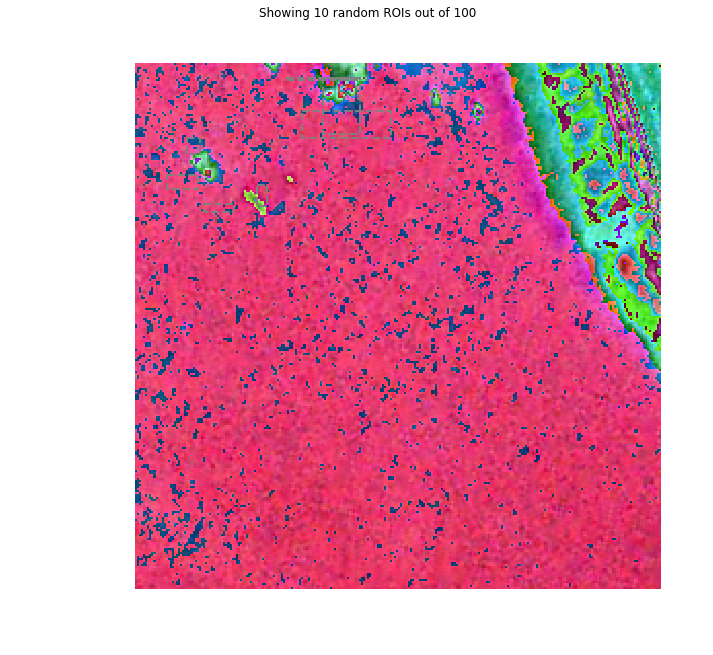

In [48]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

<Figure size 1008x1224 with 0 Axes>

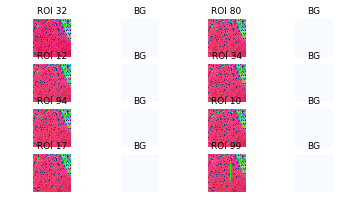

In [49]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [50]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, crop_config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   33  0.33
   33  0.33
   33  0.33
   33  0.33
   33  0.33
   33  0.33
   33  0.33
   33  0.33
   33  0.33
   33  0.33
Average percent: 0.33
